# Cartoon Set

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
from scipy import linalg
from random import uniform
from sklearn.decomposition import PCA
import cv2
import bz2
import pickle
import _pickle as cPickle


In [2]:
# Mount directories
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import my utility functions
import sys
sys.path.append('/content/gdrive/My Drive/CSCI1430_Final_Project/')
from utils import *

In [0]:
# These two function weren't working in the utils file
import bz2
import pickle
import _pickle as cPickle
"""
Load any compressed pickle file
"""
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

from random import uniform
"""
Generates novel face based on the following formula:
New Face = (mean face) + sum(random scalar * eigenfaces)
"""
def generate_new_face(mean_face, eigenfaces, height, width, minScale=-3000, maxScale=3000):
  new_face = mean_face.reshape(height,width)
  weights = []
  for i in range(len(eigenfaces)):
    random_scalar = uniform(minScale, maxScale)
    weights.append(random_scalar)
    new_face = new_face + random_scalar * eigenfaces[i].reshape(height,width)
  return new_face

Get Images

In [5]:
path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/cartoon_set_2k_greyscale.pbz2"
cartoon_set = decompress_pickle(path)

cartoon_set = np.asarray(cartoon_set)

# Number of people in dataset, should be 10k. There's also a larger dataset but we don't need it
print(len(cartoon_set))

num_cartoons, height, width = cartoon_set.shape


3000


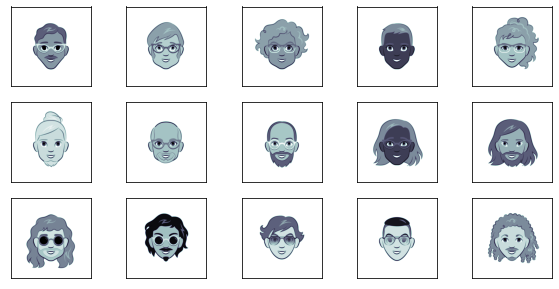

In [6]:
show_images_in_dataset(cartoon_set)

In [0]:
#### THIS CRASHES RAM. USE SKLEARN INSTEAD

# # Reshape data from (number of images, height of image, width of image) to (number of images, h*w)
# cartoon_data = cartoon_set.reshape(num_cartoons, height*width)

# # choose number of components, if I remember correctly, 40 is the number of components
# # that the human face varies by. Pretty sure there's some mathy-graph way you 
# # can show to decide what the optimal number is (might be like an elbow plot)
# # We should probably do that math at some point
# num_components=40

# # Call my pca function that may or may not work
# # Only using 2000 of the 10k photos and as greyscale cuz otherwise it crashes
# data_pca, eigenvecs, eigenvals, mean_face = pca_using_svd(cartoon_data, num_components)

# # Reshape flattened eigenvectors into images
# eigenfaces = eigenvecs.T.reshape((num_components, height, width, channels))

In [0]:
# Doing max number of components using SKLearn's crashes
# Doing color images with barely any components also crashes
# Doing small number of components using our's also crashes
# only choice is to use sklearn


# choose number of components, must be low to not crash ~100
num_components=100
pca = PCA(n_components=num_components, svd_solver='randomized',
          whiten=True).fit(cartoon_set.reshape(num_cartoons, -1))
mean_face = pca.mean_
eigenvecs = pca.components_
# Reshape flattened eigenvectors into images
eigenfaces = pca.components_.reshape((num_components, height, width))


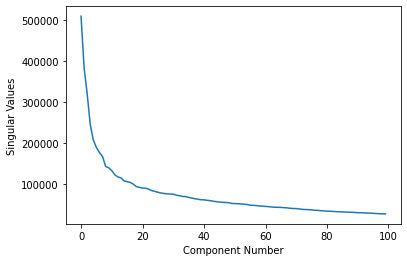

In [9]:
## Plotting components
plt.plot(pca.singular_values_)
plt.ylabel("Singular Values")
plt.xlabel("Component Number")
plt.show()

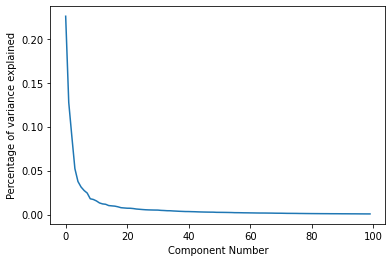

First 5 components explain 0.5320568292177215% variance in the data
First 20 components explain 0.7560122661348828% variance in the data
First 40 components explain 0.857132852564595% variance in the data
First 50 components explain 0.886218031881697% variance in the data
Note that you need 50 components to explain .847 of variance in lfw crop dataset


In [10]:
# Explained variance
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Percentage of variance explained")
plt.xlabel("Component Number")
plt.show()

print("First 5 components explain {}% variance in the data".format(np.sum(pca.explained_variance_ratio_[0:5])))
print("First 20 components explain {}% variance in the data".format(np.sum(pca.explained_variance_ratio_[0:20])))
print("First 40 components explain {}% variance in the data".format(np.sum(pca.explained_variance_ratio_[0:40])))
print("First 50 components explain {}% variance in the data".format(np.sum(pca.explained_variance_ratio_[0:50])))

print("Note that you need 50 components to explain .847 of variance in lfw crop dataset")


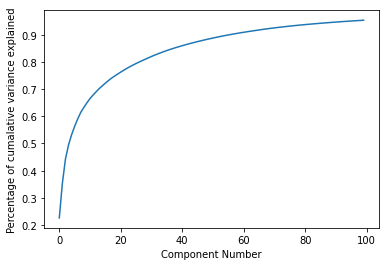

First 5 components explain 0.5633734962952649% variance in the data
First 20 components explain 0.7631843577957907% variance in the data
First 35 components explain 0.8426886897025673% variance in the data
First 50 components explain 0.888673160604519% variance in the data
Note that you need 50 components to explain .847 of variance in lfw crop dataset


In [11]:
# Different explained variance graph
cumalative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumalative_variance)
plt.ylabel("Percentage of cumalative variance explained")
plt.xlabel("Component Number")
plt.show()

print("First 5 components explain {}% variance in the data".format(cumalative_variance[5]))
print("First 20 components explain {}% variance in the data".format(cumalative_variance[20]))
print("First 35 components explain {}% variance in the data".format(cumalative_variance[35]))
print("First 50 components explain {}% variance in the data".format(cumalative_variance[50]))

print("Note that you need 50 components to explain .847 of variance in lfw crop dataset")


# An eigenvalue greater than 1 indicates that principal component accounts for more variance than accounted by one of the original variables in standardized data. This could be used to threshold to determine the number of eigenvectors.


Top 15 eigenfaces by variance


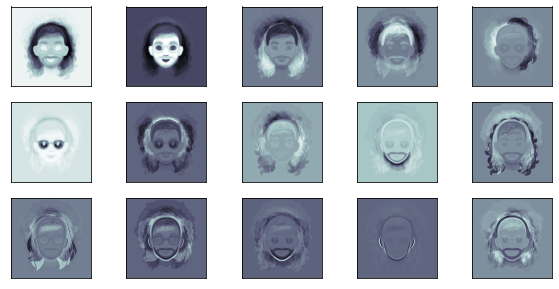

In [12]:
show_images_in_dataset(eigenfaces)
print("Top 15 eigenfaces by variance")

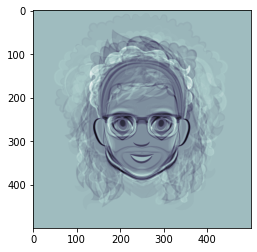

In [13]:
# Cartoon Generation

new_face = generate_new_face(mean_face, eigenfaces, height, width, -3000, 3000)
imgplot = plt.imshow(new_face, cmap=plt.cm.bone)


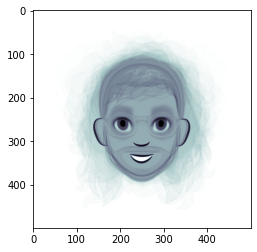

In [14]:
# Here's the average of the cartoon dataset
imgplot = plt.imshow(mean_face.reshape(height,width), cmap=plt.cm.bone)


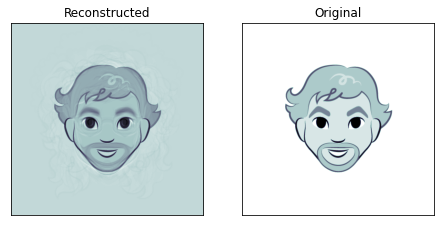

In [15]:
cartoon_to_reconstruct = cartoon_set[32]
# cartoon_to_reconstruct = np.random.rand(500, 500)
reconstructed_cartoon = reconstruct_face(cartoon_to_reconstruct, mean_face, eigenvecs)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3, 5, 1, xticks=[], yticks=[])
ax.imshow(reconstructed_cartoon, cmap=plt.cm.bone)
ax.title.set_text('Reconstructed')
ax = fig.add_subplot(3, 5, 2, xticks=[], yticks=[])
ax.imshow(cartoon_to_reconstruct, cmap=plt.cm.bone)
ax.title.set_text('Original')



(500, 500)


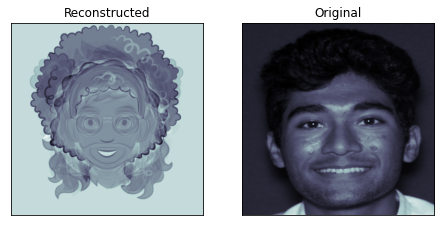

In [16]:
path_to_myself = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/neilBW.png"

me = cv2.imread(path_to_myself, 0)
me = cv2.resize(me, (500, 500))
me = np.asarray(me)
print(me.shape)

cartoon_to_reconstruct = me
# cartoon_to_reconstruct = np.random.rand(500, 500)
reconstructed_cartoon = reconstruct_face(cartoon_to_reconstruct, pca.mean_, pca.components_)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3, 5, 1, xticks=[], yticks=[])
ax.imshow(reconstructed_cartoon, cmap=plt.cm.bone)
ax.title.set_text('Reconstructed')
ax = fig.add_subplot(3, 5, 2, xticks=[], yticks=[])
ax.imshow(cartoon_to_reconstruct, cmap=plt.cm.bone)
ax.title.set_text('Original')

(500, 500)


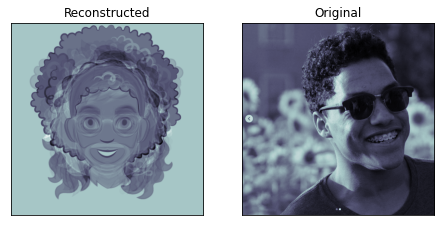

In [19]:
path_to_myself = "/content/Screen Shot 2020-05-03 at 11.18.22 PM.png"

me = cv2.imread(path_to_myself, 0)
me = cv2.resize(me, (500, 500))
me = np.asarray(me)
print(me.shape)

cartoon_to_reconstruct = me
# cartoon_to_reconstruct = np.random.rand(500, 500)
reconstructed_cartoon = reconstruct_face(cartoon_to_reconstruct, pca.mean_, pca.components_)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3, 5, 1, xticks=[], yticks=[])
ax.imshow(reconstructed_cartoon, cmap=plt.cm.bone)
ax.title.set_text('Reconstructed')
ax = fig.add_subplot(3, 5, 2, xticks=[], yticks=[])
ax.imshow(cartoon_to_reconstruct, cmap=plt.cm.bone)
ax.title.set_text('Original')